# Matrix Factorization Recommenders
## DSC 672: Data Science Capstone
## Group 2: Anthony Anekwe, Ross Pollock, Nick Short

In [1]:
from google.colab import drive
drive.mount('/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /drive


In [2]:
!pip install scikit-surprise

     |████████████████████████████████| 11.8MB 338kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1670928 sha256=4d2beac6c4c46ae6b43a67eca57860c0744b3b82374dee2fdbfc9eed276f63de
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


### Libraries

In [3]:
# Data Loading 
import numpy as np
import pandas as pd
import sqlite3 as sql
from surprise import Dataset, Reader

# Recommender Systems (Matrix Factorization)
from surprise import SVD, NMF

# Model Selection
from sklearn.model_selection import train_test_split

# Data Viz
import matplotlib.pyplot as plt
import seaborn as sns 

# Default Dictionary
from collections import defaultdict 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Data Loading

In [4]:
# Path to Database
db_path = '/drive/My Drive/DSC672_Project/datasets/climbing_full.sqlite'

# Load User Ratings
with sql.connect(db_path) as conn:
  ratings = pd.read_sql_query('''
    SELECT user_id, route_id, AVG(user_star) as rating
    FROM ticks
    WHERE user_star 
    BETWEEN 0 AND 4
    GROUP BY user_id, route_id;
  ''',conn)

# Read In Routes
route_csv = '/drive/My Drive/DSC672_Project/datasets/cleaned_routes.csv'
clean_routes = pd.read_csv(route_csv,index_col=0)

# Remove any Non-Clean Routes
ratings = ratings[ratings.route_id.isin(clean_routes.id.unique())]

## Subset Data

In [5]:
def rating_info(
    df:pd.DataFrame,
    uid_col:str = 'user_id',
    iid_col:str = 'route_id'
  ) -> None:
  '''
  Prints out simple info about ratings DataFrame
    - Total Number of Ratings
    - Number of Users
    - Number of Items
    - Sparsity of User Item Matrix
  '''
  n_users = len(df[uid_col].unique()) 
  n_items = len(df[iid_col].unique())
  n_rating = df.shape[0]

  sparsity = 1 - n_rating / (n_users * n_items)
  print(f'Number of Ratings: {df.shape[0]}')
  print(f'Number of Users: {n_users}')
  print(f'Number of Items: {n_items}')
  print(f'Sparsity: {sparsity:0.5f}')

def min_interactions(
    df : pd.DataFrame,
    n : int,
    uid_col : str = 'user_id',
    iid_col : str = 'route_id'  
  ) -> pd.DataFrame:
  '''
  Removes Items and Users with less than n ratings
  '''
  unique_uid = set(df[uid_col].value_counts(sort=False).loc[lambda x: x > n].index)
  unique_iid = set(df[iid_col].value_counts(sort=False).loc[lambda x: x > n].index)

  return df[df[uid_col].isin(unique_uid) & df[iid_col].isin(unique_iid)]


rating_subset = min_interactions(ratings,25)
route_ids = rating_subset.route_id.unique()

### Train Test Split


In [6]:
train_ds, test_ds = train_test_split(rating_subset,test_size=0.2)
train_ds, val_ds  = train_test_split(train_ds,test_size=(1/8))

### Format Pandas DFs to Surprise Format

In [7]:
data_reader = Reader(rating_scale=(0,4))

train_ds_ = Dataset.load_from_df(train_ds,data_reader)

### Basic SVD

In [8]:
def eval_val_set(model,ds):
  '''
  Evaluate Surpise Model
  Inputs:
    model: Surpise Model
    ds: pd.DataFrame - columns = uid | iid | rating
  Returns MAE, RMSE
  '''
  absolute_error = np.empty(len(ds))
  squared_error  = np.empty(len(ds))
  for idx, row in enumerate(ds.to_numpy()):
    uid, iid, rui = row  
    _,_,_,est,_ = model.predict(uid,iid)
    absolute_error[idx] = np.abs(rui-est)
    squared_error[idx]  = (rui-est)**2  
  return absolute_error.mean(), np.sqrt(squared_error.mean())

In [9]:
params = {'n_factors':[3,5,7,10,20,30,50,75,100],'reg':np.logspace(-1,-5,5)}

results = np.empty(shape=(len(params['n_factors'])*len(params['reg']),4),dtype=object)
i = 0
for dims in params['n_factors']:
  for reg in params['reg']:
    model = SVD(n_factors=dims,reg_all=reg,n_epochs=25)
    model.fit(train_ds_.build_full_trainset())
    mae, rmse = eval_val_set(model,val_ds)

    results[i] = [dims,reg,mae,rmse]
    i = i+1

In [10]:
results_df = pd.DataFrame(results)
results_df.columns = ['Latent Factors','Regularization','MAE','RMSE']
results_df = results_df.astype({'Latent Factors':np.int,'Regularization':np.float64,'MAE':np.float64,'RMSE':np.float64})
print(results_df)

    Latent Factors  Regularization       MAE      RMSE
0                3         0.10000  0.473287  0.598412
1                3         0.01000  0.466869  0.595637
2                3         0.00100  0.466601  0.595824
3                3         0.00010  0.466623  0.595754
4                3         0.00001  0.466739  0.595981
5                5         0.10000  0.473331  0.598467
6                5         0.01000  0.467444  0.596156
7                5         0.00100  0.467021  0.596219
8                5         0.00010  0.467297  0.596636
9                5         0.00001  0.467124  0.596580
10               7         0.10000  0.473303  0.598472
11               7         0.01000  0.467386  0.596045
12               7         0.00100  0.467975  0.597299
13               7         0.00010  0.468015  0.597660
14               7         0.00001  0.467596  0.597185
15              10         0.10000  0.473377  0.598476
16              10         0.01000  0.467926  0.596920
17        

In [11]:
results_df.groupby('Latent Factors').min()

,Regularization,MAE,RMSE
Latent Factors,,,
3,0.00001,0.466601,0.595637
5,0.00001,0.467021,0.596156
7,0.00001,0.467386,0.596045
10,0.00001,0.467926,0.596920
20,0.00001,0.469404,0.598612
30,0.00001,0.470416,0.598797
50,0.00001,0.473028,0.599109
75,0.00001,0.474466,0.599490
100,0.00001,0.474915,0.599920


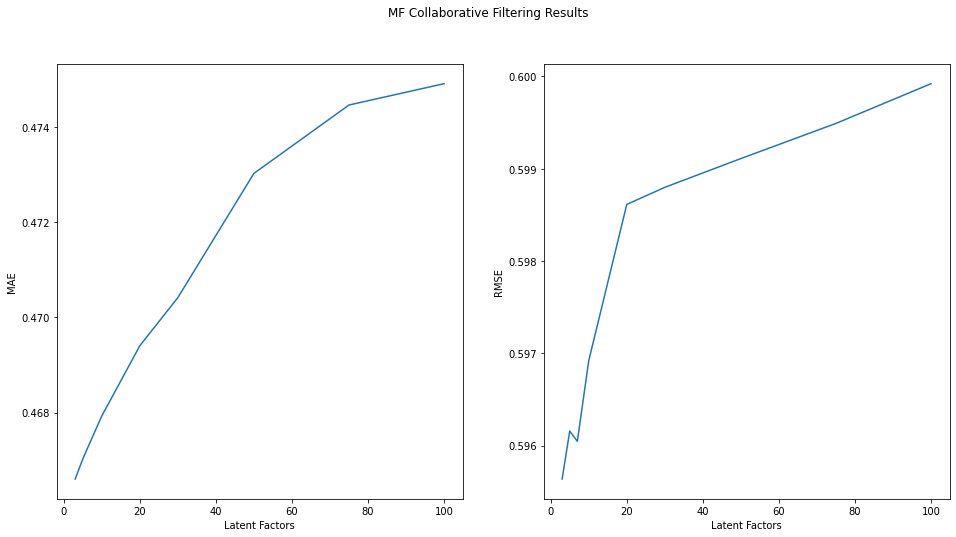

In [12]:
fig, axs = plt.subplots(ncols=2,figsize=(16,8))
plot_df = results_df.groupby('Latent Factors').mean()
sns.lineplot(x=plot_df.index,y='MAE',data=plot_df, ax=axs[0])
sns.lineplot(x=plot_df.index,y='RMSE',data=plot_df, ax=axs[1])
fig.suptitle('MF Collaborative Filtering Results')
plt.show()

In [13]:
print(results_df[results_df.MAE == results_df.MAE.min()])
print(results_df[results_df.RMSE == results_df.RMSE.min()])

   Latent Factors  Regularization       MAE      RMSE
2               3           0.001  0.466601  0.595824
   Latent Factors  Regularization       MAE      RMSE
1               3            0.01  0.466869  0.595637


### Test Set Score

In [14]:
def relevant_items(df,user_col,item_col,rate_col,threshold=-1):
  '''
  Generates Users' Set of relevant items 
  where the explicit rating is greater than 
  the threshold which defaults to 2.5
  '''
  df = df[df[rate_col] > threshold]
  df = df.groupby(user_col).agg({item_col:lambda x: set(x)})
  return df 

def precision_recall_at_k(model,ds,item_set,k_vals=[1,5,10,25]):
  precision, recall = defaultdict(np.array), defaultdict(np.array)
  for k in k_vals:
    precision[k] = np.empty(len(ds))
    recall[k] = np.empty(len(ds))
  for pdx, uid in enumerate(ds.index):
    est_ratings = np.empty(len(item_set))
    for idx,iid in enumerate(item_set):
      _,_,_,est,_ = model.predict(uid,iid)
      est_ratings[idx] = est 
    top_k = np.argsort(est_ratings)[::-1][:max(k_vals)]
    for k in k_vals:
      top_k_prime = top_k[:k]
      top_k_prime = set(item_set[top_k_prime])
      rel = ds.loc[uid]['route_id'] 
      rel_and_rec = top_k_prime & rel
      precision[k][pdx] = len(rel_and_rec) / float(k)
      recall[k][pdx] = len(rel_and_rec) / float(len(rel)) if len(rel) > 0 else 0
  for k in k_vals:
    precision[k] = precision[k].mean() 
    recall[k] = recall[k].mean()
  return precision, recall

In [15]:
full_train_set = pd.concat([train_ds,val_ds])
full_train_set = Dataset.load_from_df(full_train_set,data_reader)

In [16]:
final_mf_model = SVD(n_factors=3,biased=True,reg_all=1e-4,n_epochs=25)
final_mf_model.fit(full_train_set.build_full_trainset())

In [17]:
eval_val_set(final_mf_model,test_ds)

(0.4646189466242704, 0.5939058174248759)

In [18]:
# Build Test Dataset to Calculate Precision / Recall @ k 
test_ds = relevant_items(test_ds,'user_id','route_id','rating')

In [19]:
%%time
precision, recall = precision_recall_at_k(
    final_mf_model,test_ds,route_ids,
    k_vals=[1,5,10,25]
)

CPU times: user 16min 52s, sys: 1.34 s, total: 16min 53s
Wall time: 16min 55s


In [20]:
precision

defaultdict(<function numpy.array>,
            {1: 0.0020016012810248197,
             5: 0.0022017614091273023,
             10: 0.0021116893514811852,
             25: 0.0020856685348278623})

In [21]:
recall

defaultdict(<function numpy.array>,
            {1: 8.813058913722395e-05,
             5: 0.0006570981063239272,
             10: 0.001174000258116241,
             25: 0.0029275521941002866})

## Save MF Model

In [22]:
from surprise.dump import dump
recommender_path = '/drive/My Drive/DSC672_Project/Recommenders/'
dump(file_name=recommender_path + 'mf_recommender.pickle',
     algo=final_mf_model)